# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional: Análise de Imagens Médicas

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**.


## 1. Introdução

Uma determinada fintech focada em consumidores finais pessoa física constataou um grande número de fraudes em transações bancárias.

O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal, e após isso transferir para outras contas desconhecidas. 

Após análises pelas equipes de segurança, os protocolos de utilização da senha foram realizados em conformidade, ou seja, cada cliente autenticou com sua própria senha de maneira regular.

Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo parecido.

Uma das formas de solucionar ou minimizar este problema é com a utilização de outras formas de autenticação, sobretudo em operações críticas, como a obtenção de crédito pessoal.

Desta forma podemos implementar uma verificação de identidade com prova de vida (liveness), que utilize uma verificação e identificação facial. 

Caso o cliente não seja autenticado, ele será atendido por uma esteira dedicada e as evidências da não identificação serão encaminhadas para a área de IA para validação dos parâmetros e limiares para aperfeiçoamento do modelo.

Será necessário construir:

* Detector de faces
* Identificação de faces (podendo ser um comparador entre um rosto de documento e outra da prova de vida)
* Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.


>Formas alternativas de prover a identificação e prova de vivacidade, além destas que foram solicitadas poderão ser submetidas.


<p align="center">
    <img src="imagens/liveness.jpg">
</p>

Imagem retirada do [Grunge](https://www.grunge.com/192826/company-testing-robocop-facial-recognition-software-with-us-police/).

## 2. Instruções

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas.

Iremos constuir uma forma de validar se uma determinada imagem foi ou não adulterada e se trata de uma produção fraudade.

Existem diversas formas de validar a vivacidade, e neste sentido conto com a criatividade de vocês dado que já dominam encontrar uma face numa imagem, aplicar marcos faciais e até mesmo construir uma rede neural convulacional.

A abordagem mais simples é pela construção de uma rede neural com imagens de fotos de rostos de outras fotos e fotos de rostos sem modificações. Tal classificador deverá classificar se dada imagem possui vivacidade ou não com uma pontuação de probabilidade.

Referências que abordam o tema para servir de inspiração:

1. [PyImageSearch](https://pyimagesearch.com/2019/03/11/liveness-detection-with-opencv/), Liveness detection with OpenCV;
2. [Kickertech](https://kickertech.com/face-liveness-detection-via-opencv-and-tensorflow/), Liveness detection via OpenCV and Tensorflow.
3. [Towards Data Science](https://towardsdatascience.com/real-time-face-liveness-detection-with-python-keras-and-opencv-c35dc70dafd3?gi=24f8e1b740f9), Real-time face liveness detection with Python, Keras and OpenCV.

Este projeto poderá ser feita por grupos de até 4 pessoas.
Caso este projeto seja substitutivo, deverá ser realizado por apenas uma pessoa.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Claudio Manuel           | RM 346353      | 1IAR |
| Jonas Zarpellon          | RM 345724      | 1IAR |
| Rafael Yuji              | RM 346108      | 1IAR |

## 3. Abordagem e organização da solução do problema (2 pontos)

Como o grupo pretende deteccar a prova de vivacidade de uma determinada imagem? Quais os passos e os building blocks deste processo?

**Resposta**: Abordamos o problema proposto como um problema de classifificação binária (imagem real / imagem fake). Para a resolução desse problema, estamos propondo utilizar uma rede neural convolucional, que ficará disponível como um serviço passivo. O input dessa rede é uma imagem, que é classificada como real ou fake. Essa abordagem é mais flexível do que outras alternativas propostas, como por exemplo a detecção em tempo real ou a detecção de movimentos faciais, pois permite a realização de processamento em lote e não depende de tecnologias específicas na ponta do usuário.

- Estamos utilizando um banco de imagens crowdsourced publicamente disponível no kaggle, contendo versões originais e versões forjadas de selfies:\
https://www.kaggle.com/datasets/faber24/lcc-fasd

- Para o pre-processamento, optamos por não realizar a identificação e extração da face, uma vez que é possível identificar artefatos como reflexos e pixelização fora da área da face, e a remoção dessa informação pode prejudicar o modelo. Apenas aplicamos um preprocessamento embutido no modelo, para padronizar o tamanho das imagens. Dessa forma é possível alimentar a rede com imagens em formatos arbitrários.

- A arquitetura da CNN foi baseada na LeNet, a partir da qual desenhamos um hipermodelo. Através de técnicas de otimização bayesiana (keras-tuner), o hipermodelo foi dimensionado, treinado e posteriormente encapsulado em um binário para deploy em ambiente produtivo.

## 4. Desenvolvimento da solução (5,5 pontos)

Detalhe o passo-a-passo do algoritmo de deteção de vivacidade.
Se optar pela construção e treinamento de um modelo de redes neurais convulucionais, apresente a arquitetura, prepare os dados de treinamento, realize o treinamento.

#### dependências

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import expand_dims
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Lambda, Resizing, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras_tuner import BayesianOptimization

### 4.1 Organização de dados para treinamento de modelo de liveness (2 pontos)

#### carga dos dados

In [2]:
# dataset que será utilizado para o treinamento
train_data = image_dataset_from_directory(
    'datasets/LCC_FASD/LCC_FASD_training',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=None,
    # image_size=(100, 100),
    shuffle=True,
)
# dataset que será utilizado para a validação do modelo durante o treinamento
validation_data = image_dataset_from_directory(
    'datasets/LCC_FASD/LCC_FASD_evaluation',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=None,
    # image_size=(100, 100),
    shuffle=True,
)
# holdout data, será utilizado após o treinamento para avaliar o modelo
holdout_data = image_dataset_from_directory(
    'datasets/LCC_FASD/LCC_FASD_development',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=None,
    # image_size=(100, 100),
    shuffle=True,
)

Found 8299 files belonging to 2 classes.
Found 7580 files belonging to 2 classes.
Found 2948 files belonging to 2 classes.


#### classes

In [3]:
# exibe as classes carregadas
labels = train_data.class_names
print ('classes: ', labels)

classes:  ['real', 'spoof']


#### distribuição das classes

In [4]:
def plot_classes(dataset, title):
	class_counter = np.zeros(len(labels))
	for image, label in dataset:
		class_counter[label] += 1

	ds = pd.DataFrame(class_counter, columns=['count'])
	ds['class'] = labels
	fig = plt.figure(figsize=(10, 4))
	sns.barplot(data=ds, orient='h', x='count', y='class')
	plt.title(title)
	plt.show()

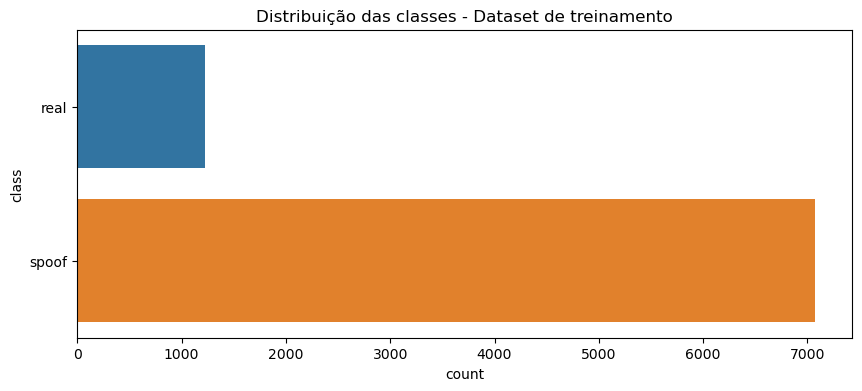

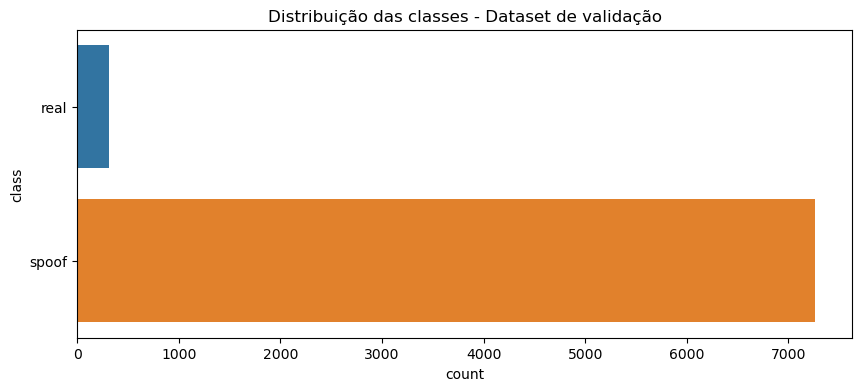

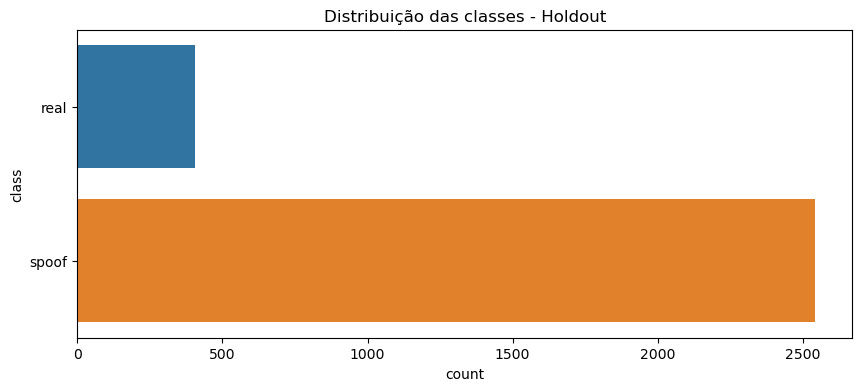

In [5]:
# exibe graficamente a distribuição das classes
plot_classes(train_data, 'Distribuição das classes - Dataset de treinamento')
plot_classes(validation_data, 'Distribuição das classes - Dataset de validação')
plot_classes(holdout_data, 'Distribuição das classes - Holdout')

#### balanceamento das classes

In [6]:
# equilibra os datasets por downsampling da classe majoritária
def balance_dataset(dataset):
	data_true = dataset.filter(lambda x, y: y == 0)
	class_counter = 0
	for image, label in data_true:
		class_counter += 1
	data_false = dataset.filter(lambda x, y: y == 1)
	balanced = data_true.concatenate(data_false.take(class_counter))
	return balanced.shuffle(buffer_size=2000)

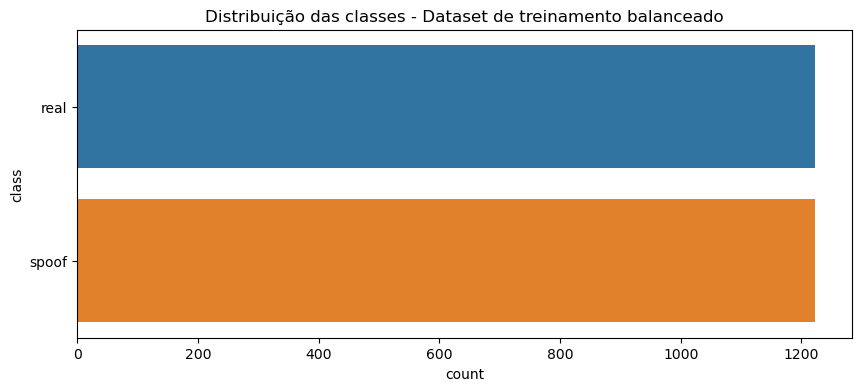

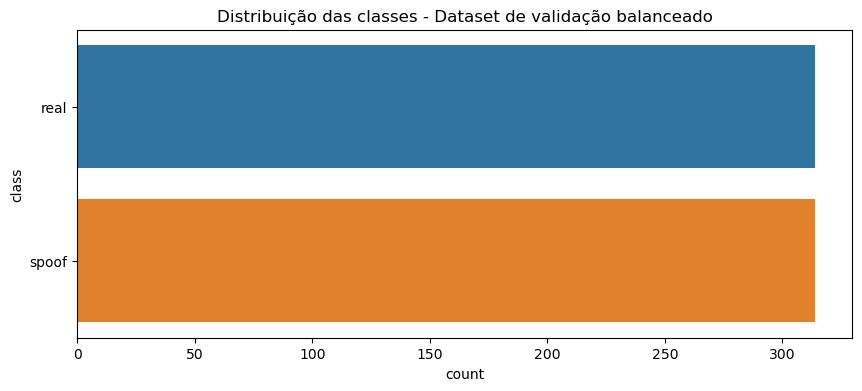

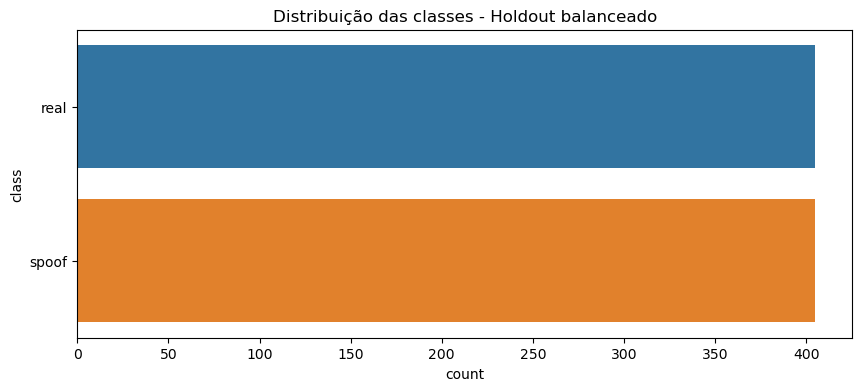

In [7]:
balanced_train_data = balance_dataset(train_data)
plot_classes(balanced_train_data, 'Distribuição das classes - Dataset de treinamento balanceado')
balanced_validation_data = balance_dataset(validation_data)
plot_classes(balanced_validation_data, 'Distribuição das classes - Dataset de validação balanceado')
balanced_holdout_data = balance_dataset(holdout_data)
plot_classes(balanced_holdout_data, 'Distribuição das classes - Holdout balanceado')

#### visualização das classes

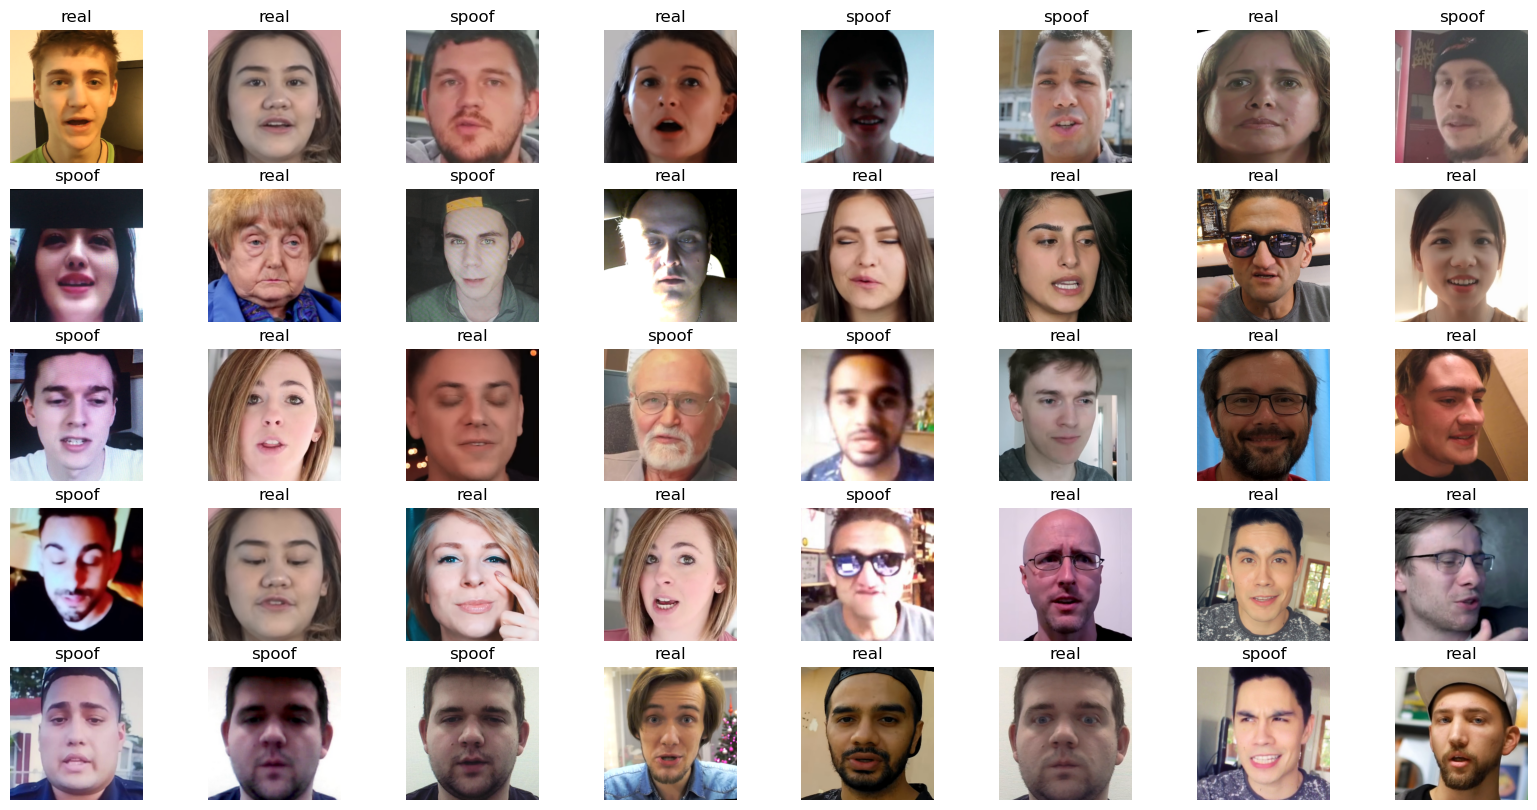

In [8]:
# visualização das classes
fig = plt.figure(figsize=(20, 10))
for i, (image, label) in enumerate(balanced_train_data.take(40)):
	ax = fig.add_subplot(5, 8, i + 1) 
	ax.imshow(image.numpy().astype("uint8"))
	ax.set_title(labels[label])
	ax.axis('off')
plt.show()

#### pipeline de preprocessamento: resizing

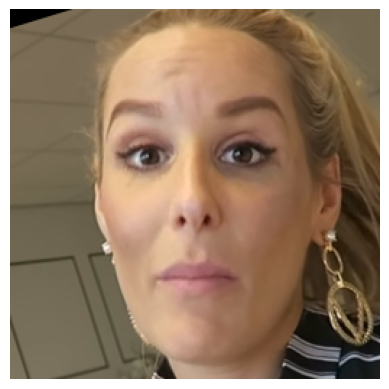

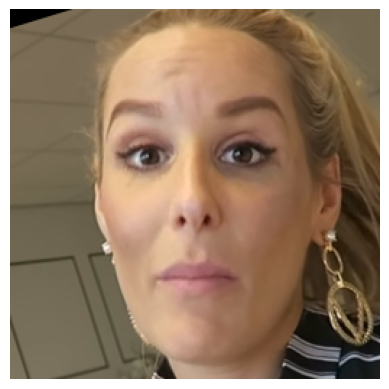

In [48]:
# vamos validar a camada de redimensionamento
resizing_layer = Resizing(256, 256)
# vamos testar a camada com uma imagem
images = train_data.take(1)
for image, label in images:
	# exibe a imagem original
	plt.imshow(image.numpy().astype("uint8"))
	plt.axis('off')
	plt.show()
	# exibe a imagem redimensionada
	image = expand_dims(image, 0)
	image = resizing_layer(image)
	plt.imshow(image[0].numpy().astype("uint8"))
	plt.axis('off')
	plt.show()

### 4.2 Treinamento de modelo de liveness (1,5 pontos)

#### definição do hipermodelo

In [10]:
def hypermodel(hp):

	# Inicialização do modelo
	model = Sequential()

	# camada de entrada com dimensão variável
	model.add(Input(shape=(None, None, 3)))

	# camada de resizing
	model.add(resizing_layer)

	# camada de normalização
	model.add(Lambda(lambda x: x / 255.0)) 

	# escala para as camadas convolucionais
	conv_scale = hp.Int('conv_scale', 1, 6, step=1)

	# dropout
	dropout = hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

	# regularizações
	l1 = hp.Choice('l1', [0.1, 0.01, 0.001])
	l2 = hp.Choice('l2', [0.1, 0.01, 0.001])
	# l1_dense = hp.Choice('l1_dense', [1.0, 0.5, 0.1])
	# l2_dense = hp.Choice('l2_dense', [1.0, 0.5, 0.1])

	# camada convolucional
	model.add(Conv2D(
		filters = 8 * conv_scale,
		kernel_size = hp.Int('kernel_size_1', 3, 5, step=2),
		activation = 'relu',
		padding = 'same',
		kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2),
		bias_regularizer=regularizers.L1L2(l1=l1, l2=l2),
	))

	# camada de pooling
	model.add(MaxPooling2D(pool_size=(4, 4)))

	# camada de dropout
	model.add(Dropout(dropout))
	
	# camada convolucional
	model.add(Conv2D(
		filters = 16 * conv_scale, # o dobro da primeira camada
		kernel_size = hp.Int('kernel_size_2', 3, 5, step=2),
		activation = 'relu',
		padding = 'same',
		kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2),
		bias_regularizer=regularizers.L1L2(l1=l1, l2=l2),
	))

	# camada de pooling
	model.add(MaxPooling2D(pool_size=(4, 4)))

	# camada de dropout
	model.add(Dropout(dropout))

	# camada flatten
	model.add(Flatten())

	# camadas densas
	dense_scale = hp.Int('dense_scale', 1, 6, step=1)

	model.add(Dense(
		units = 48 * dense_scale, 
		activation='relu',		
		)) 
	model.add(Dense(
		units = 24 * dense_scale, 
		activation='relu',		
		)) 

	# camada de saída
	model.add(Dense(units = 1, activation='sigmoid'))

	model.compile(
		loss='binary_crossentropy', 
		optimizer='adam',
		metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'],
		)	

	return model


#### early stopping

In [11]:
# utiliza early stopping para parar o treinamento quando não houver mais melhora
# retorna o melhor modelo salvo pelo checkpoint
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    min_delta=0.01,
    patience=4,
    verbose=0,
    restore_best_weights=True,
)

#### otimização dos hiperparâmetros

In [12]:
# inicializa o otimizador bayesiano
optimizer = BayesianOptimization(
	hypermodel = hypermodel,
	objective = 'val_loss',
	max_trials = 30,
	executions_per_trial=2, 
	directory = 'search',
	project_name = 'liveness_detection',
)
# apresenta o espaço de busca
optimizer.search_space_summary()

INFO:tensorflow:Reloading Tuner from search\liveness_detection\tuner0.json
Search space summary
Default search space size: 7
conv_scale (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
l1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}
l2 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}
kernel_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
kernel_size_2 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
dense_scale (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}


In [13]:
# realiza os trials
optimizer.search(
  x = balanced_train_data.batch(100),
  epochs=1000,
  batch_size=100,
  validation_data=balanced_validation_data.batch(100),
  callbacks=[early_stopping],
)

Trial 30 Complete [00h 11m 49s]
val_loss: 0.7029275298118591

Best val_loss So Far: 0.6945031583309174
Total elapsed time: 03h 47m 31s
INFO:tensorflow:Oracle triggered exit


#### re-treinamento do modelo otimizado

{'conv_scale': 2, 'dropout': 0.2, 'l1': 0.001, 'l2': 0.001, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dense_scale': 4}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 16)        0         
                                                                 
 c

None

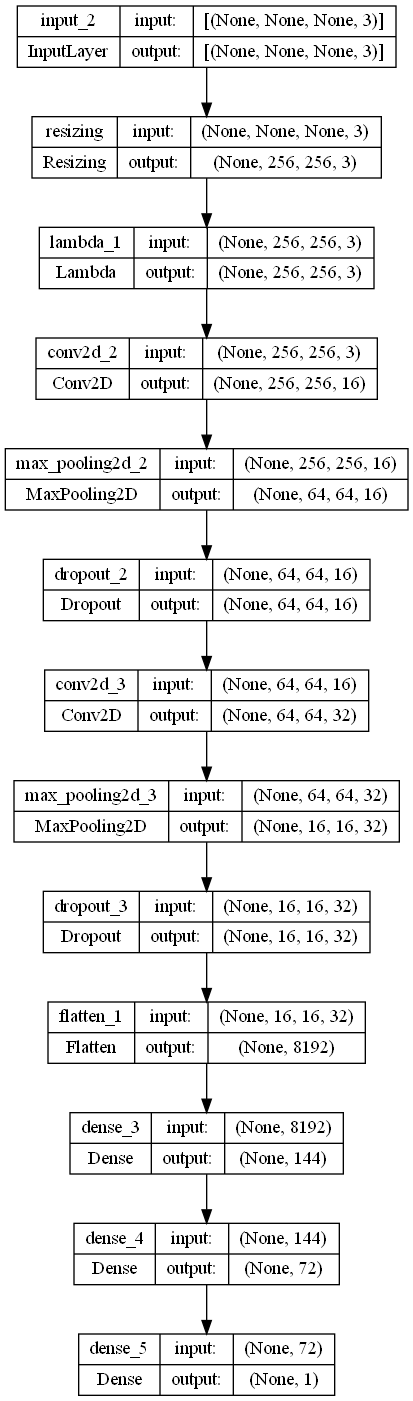

In [14]:
# recupera o melhor modelo e apresenta o resumo
best_hp = optimizer.get_best_hyperparameters()[0]
print(best_hp.values)
best_hp.values['scale'] = 3
best_hp.values['dense_scale'] = 3
best_hp.values['dropout_1'] = 0.3
best_hp.values['dropout_0'] = 0.3
model = hypermodel(best_hp)
display(model.summary())
filename = 'model.png'
plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)

In [15]:
# treina novamente o melhor modelo para registrar o aprendizado e avaliar o histórico
history = model.fit(
  balanced_train_data.batch(100),
  epochs=1000,
  batch_size=100,
  validation_data=balanced_validation_data.batch(100),
  callbacks=[early_stopping], 
  verbose=1)

Epoch 1/1000
25/25 [==============================] - 49s 967ms/step - loss: 1.2478 - accuracy: 0.5196 - auc: 0.5371 - precision: 0.5390 - recall: 0.2715 - true_positives: 332.0000 - true_negatives: 939.0000 - false_positives: 284.0000 - false_negatives: 891.0000 - val_loss: 1.1072 - val_accuracy: 0.4092 - val_auc: 0.4167 - val_precision: 0.4320 - val_recall: 0.5764 - val_true_positives: 181.0000 - val_true_negatives: 76.0000 - val_false_positives: 238.0000 - val_false_negatives: 133.0000
Epoch 2/1000
25/25 [==============================] - 46s 946ms/step - loss: 1.0433 - accuracy: 0.6423 - auc: 0.7145 - precision: 0.7076 - recall: 0.4849 - true_positives: 593.0000 - true_negatives: 978.0000 - false_positives: 245.0000 - false_negatives: 630.0000 - val_loss: 0.9980 - val_accuracy: 0.6194 - val_auc: 0.6716 - val_precision: 0.6126 - val_recall: 0.6497 - val_true_positives: 204.0000 - val_true_negatives: 185.0000 - val_false_positives: 129.0000 - val_false_negatives: 110.0000
Epoch 3/100

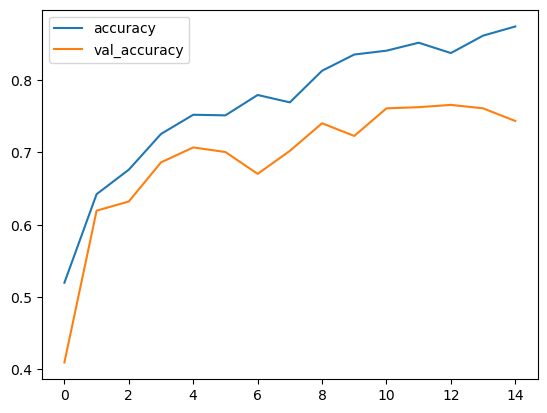

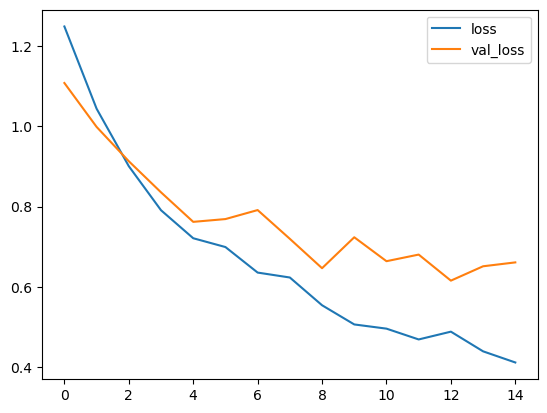

In [16]:
# apresenta o histórico de treinamento
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val_accuracy')
plt.show()
sns.lineplot(x=history.epoch, y=history.history['loss'], label='loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val_loss')
plt.show()

#### persistência do modelo

In [17]:
# salva o modelo para utilização em produção
filename = 'modelos/modelo.h5'
model.save(filename)

### 4.3 Métricas de desempenho do modelo (2 pontos)

#### avaliação do modelo

In [18]:
# avalia o modelo no conjunto de validação
model.evaluate(balanced_validation_data.batch(200))

# avalia o modelo no conjunto de holdout
model.evaluate(balanced_holdout_data.batch(200))

5/5 [==============================] - 14s 106ms/step - loss: 0.6270 - accuracy: 0.7654 - auc: 0.8499 - precision: 0.8248 - recall: 0.6741 - true_positives: 273.0000 - true_negatives: 347.0000 - false_positives: 58.0000 - false_negatives: 132.0000


[0.6270356774330139,
 0.7654321193695068,
 0.8499070405960083,
 0.8247734308242798,
 0.6740740537643433,
 273.0,
 347.0,
 58.0,
 132.0]

#### visualização das predição no dataset holdout

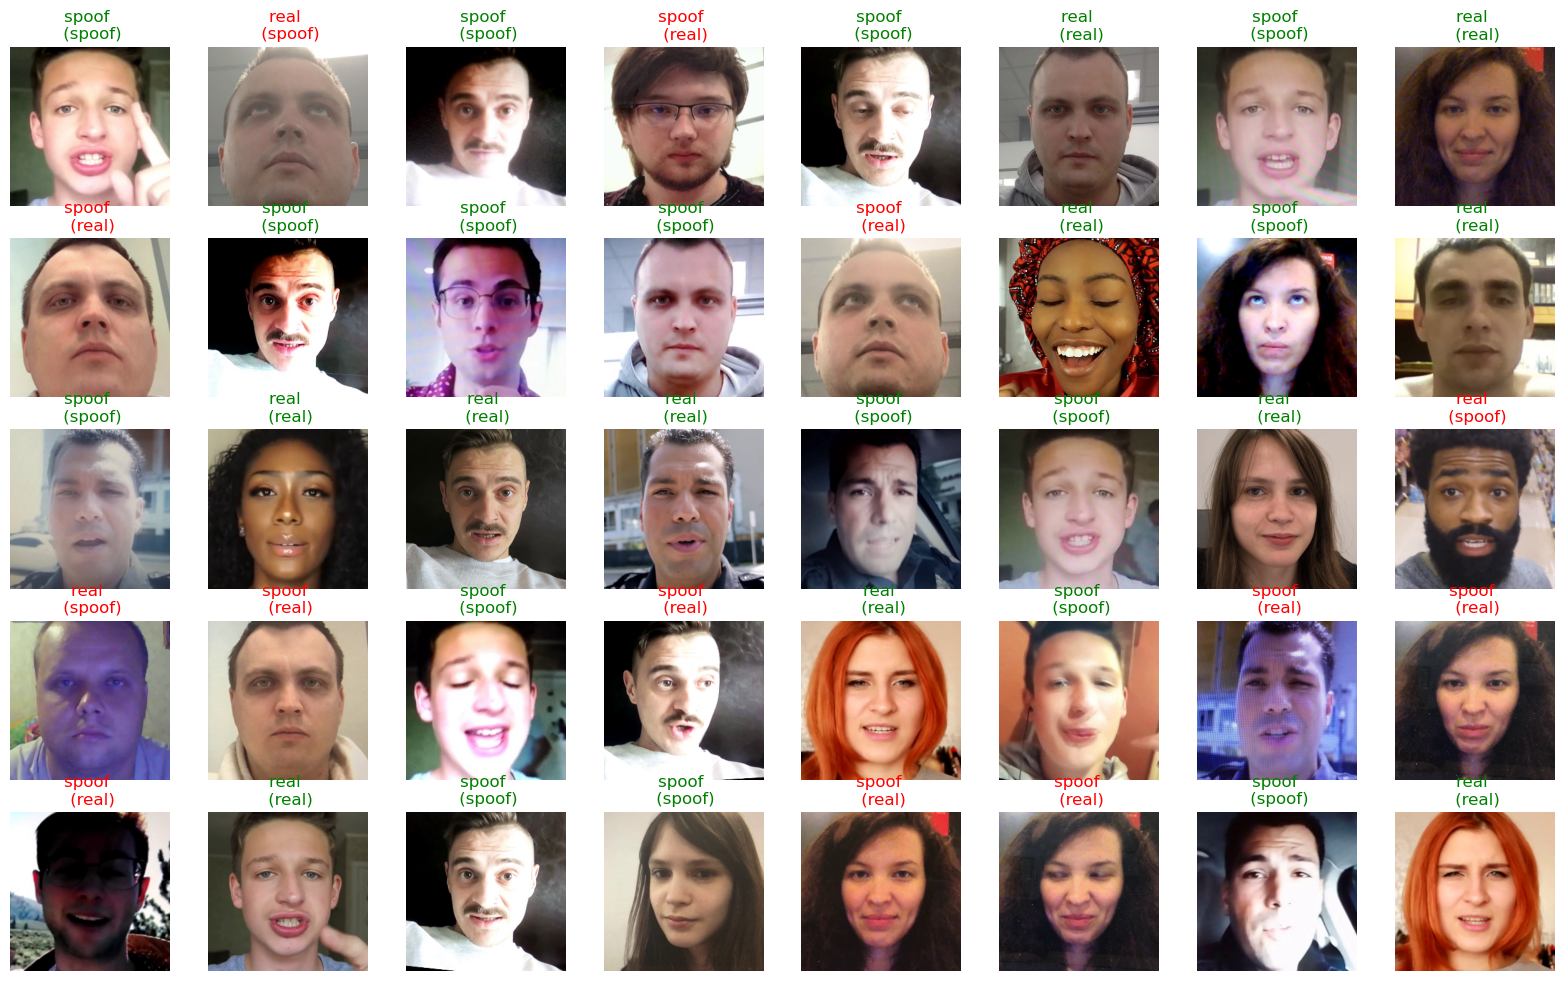

In [47]:
from IPython.display import clear_output
from tensorflow import newaxis

fig = plt.figure(figsize=(20, 12))
for i, (image, label) in enumerate(balanced_holdout_data.take(40)):
	target = label.numpy()
	prediction_prob = model.predict(image[newaxis, ...])
	prediction = 1 if prediction_prob > 0.5 else 0
	ax = fig.add_subplot(5, 8, i + 1) 
	ax.imshow(image.numpy().astype("uint8"))
	ax.set_title("{} \n ({})".format(labels[target], labels[prediction]), color=("green" if target == prediction else "red"))
	ax.axis('off')
clear_output(wait=True)
plt.show()

## 5. Teste Fim-a-Fim

Simule a operação fim-a-fim, com uma imagem de entrada forjada (foto de foto de um rosto) e outra com uma imagem de rosto, exibindo o resultado da classificação e a pontuação de cada classe.

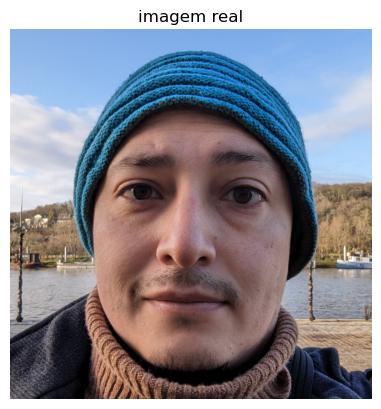

1/1 [==============================] - 0s 107ms/step
predição: real ( probabilidade: 0.025726397 )


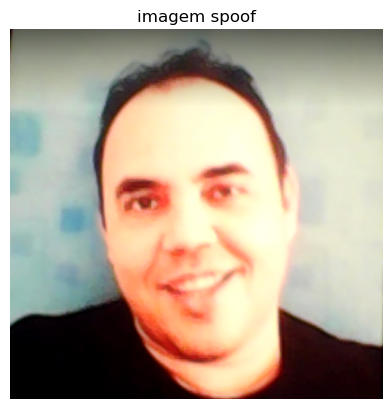

1/1 [==============================] - 0s 100ms/step
predição: spoof ( probabilidade: 0.7920627 )


In [46]:
def test_model(model, filename, title):
	# carrega a imagem
	image = load_img(filename)
	plt.imshow(image)
	plt.title (title)
	plt.axis('off')
	plt.show()
	# converte a imagem para tensor
	image = img_to_array(image)
	# image_array = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
	# realiza a predição
	prediction_prob = model.predict(image[newaxis, ...])
	prediction = 1 if prediction_prob > 0.5 else 0
	print('predição:', labels[prediction], '( probabilidade:', prediction_prob[0][0], ')')

loaded_model = load_model('modelos/modelo.h5')
test_model (loaded_model, 'images/real.png', 'imagem real', )
test_model (loaded_model, 'images/spoof.png', 'imagem spoof')

>Com a implementação da solução na forma de uma aplicação do [Streamlit](https://www.streamlit.io/) (veja a pata streamlit-app e use o template) vale 1 ponto adicional.

**Pergunta**: Se utilizou o Streamlit, compartilhe a URL do aplicativo publicado:

**Resposta**:

## 6. Conclusões (2,5 pontos)

**Pergunta**: Dado todo o estudo e pesquisa, quais foram as conclusões sobre a solução, o que funcionou, o que não funcionou e quais os detalhes que observariam numa nova versão e melhorias do processo?

**Resposta**: 

- O modelo apresentou muitos falsos negativos, o que significa baixa capacidade de previsão na classe 1, que é a classe das imagens forjadas.
- O treinamento apresentou um pouco de overfitting, e nenhuma das trials executadas passou de 75% de acurácia.
- Acreditamos que isso se deva em parte à qualidade e baixa diversidade do banco de dados. O banco apresenta muitas imagens semelhantes na classe 'spoof', e é extremamente desequilibrado.
- Esse desequilíbrio é acentuado pela técnica de downsampling utilizada, que realiza uma amostragem aleatória da classe predominante, possivelmente incluindo de forma desequilibrada imagens semelhantes que tendem a enviezar o modelo e gerar overfitting.
- É necessário aumentar e diversificar a classe 'real'.
- É necessário também realizar o downsampling manual da classe 'spoof', removendo imagens semelhantes.
- Foram incluídas técnicas de dropout e regularização nos hiperparâmetros, através das quais obtivemos uma melhora no overfitting e ganhamos até 10% na acurácia frente às primeiras versões do hipermodelo.
- Acreditamos também que houve perda de informação no redimensionamento da imagem para 256 x 256, principalmente no que tange a texturas e pixelizações. A escolha desta resolução para as convoluções foi baseada nas restrições de tempo e poder computacional disponíveis. Certamente o modelo seria beneficiado com o uso de imagens em melhor resolução.